## Introducción a PyTorch (Parte 4)

<a target="_blank" href="https://colab.research.google.com/github/pglez82/DeepLearningWeb/blob/master/labs/notebooks/Introducci%C3%B3n%20a%20PyTorch%20(Parte%204).ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Datasets y Dataloaders

Las clases `torch.utils.data.DataSet` y `torch.utils.data.DataLoader` son las clases básicas que usamos en PyTorch para la carga eficiente de datos. Manejarlas bien por tanto es crítico para llevar a cabo el entrenamiento de una red profunda con éxito. Estas dos clases tienen objetivos diferentes:
- La clase `DataSet` abstrae el concepto de conjunto de datos, almacenando los ejemplos y su etiqueta correspondiente y proveyendo métodos para la obtención de uno de estos ejemplos.
- La clase `DataLoader` encapsula a un `DataSet` y permite el acceso eficiente a lotes de ejemplos.

Es importante destacar que estas clases permiten el acceso a datasets ya creados como por ejemplo MNIST o ImageNet, así como a datasets con nuestros datos. Ten en cuenta que no solo serán datasets con imágenes sino que tendremos diferentes subclases para otros tipos de datasets.


### Carga de un DataSet
En este caso vamos a cargar el conocido dataset MNIST. Este dataset tiene 60.000 ejemplos de entrenamiento y 10.000 ejemplos de test.

In [38]:
import torch
from torch.utils.data import Dataset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.MNIST(root="data",train=True,download=True,transform=ToTensor())
test_data = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())

print("Datos de entrenamiento:")
print(training_data, end='\n\n')
print("Datos de test:")
print(test_data, end='\n\n')

Datos de entrenamiento:
Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Datos de test:
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()




Los parámetros usados son los siguientes:
- **root**. ruta donde se almacenará el dataset en nuestro dispositivo de almacenamiento.
- **train**. Especifica si queremos el conjunto de entrenamiento o el de test.
- **download**. Si le pasamos true, descarga los datos de internet si no están disponibles en el directorio root.
- **transform**. Transforma los ejemplos antes de devolverlos. Es útil para hacer **aumento de datos** que veremos en otra práctica. En este caso lo usamos para convertir las imágenes a un tensor que nos sirva para nuestra red neuronal.



### Visualizando el dataset
Vamos ahora a visualizar algunas imágenes aleatoriamente. Ten en cuenta que para realizar esto, podemos acceder a cada elemento del dataset como si fuese un simple array o una lista `training_data[i]`. Este código devuelve el ejemplo i-ésimo así como la etiqueta del mismo.

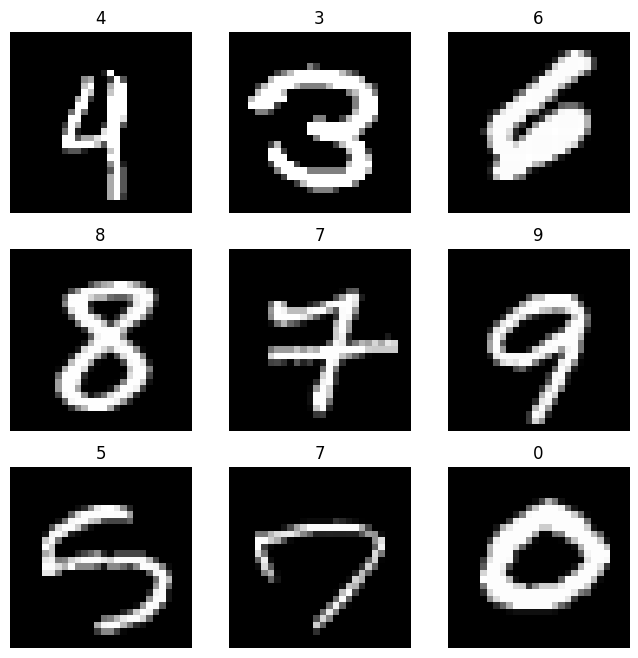

In [39]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Dividiendo el DataSet
Es común que queramos dividir el dataset de entrenamiento para separar una parte para **validación**. PyTorch tiene una función muy útil para ello que permite hacerlo rápidamente:

In [43]:
train_dataset, val_dataset = random_split(training_data, (50000, 10000))

Los objetivos devueltos por **random_split** son de tipo `Subset`. A efectos prácticos, esta clase funciona igual que DataSet y es capaz de devolvernos ejemplos individuales directamente.

### Otros tipos de DataSets (TensorDataSet)
Supongamos ahora que nuestros datos no son imágenes. Imaginemos que tenemos datos de tipo tabular. En este caso la clase que hay que utilizar es `TensorDataSet` (que extiende de `DataSet`). Esta clase recibe en su constructor un número de tensores (típicamente dos, uno para las `X` y otro para las `y`). Veamos su uso:

In [ ]:
from torch.utils.data import TensorDataset

#Generar datos para nuestro dataset.
X = torch.rand((100,2))
y = torch.randint(low=0,high=2,size=(100,))

custom_training_data = TensorDataset(X,y)
print("Imprimiento el primer ejemplo de nuestro dataset bidimensional:")
print(custom_training_data[0])

Imprimiento el primer ejemplo de nuestro dataset:
(tensor([0.9436, 0.4005]), tensor(1))


### Creando nuestra propia subclase de DataSet
Existen circunstancias en las que es adecuado crear nuestra subclase de la clase `DataSet`. Por ejemplo, esto ocurre cuando queremos cargar imágenes de un directorio. Un ejemplo de este uso sería el siguiente:

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

Para extender a DataSet siempre tendremos que implementar:
- El **constructor**, donde podemos pasarle todos los atributos que necesitemos.
- El método `__len__`, que devuelve el tamaño del dataset.
- El método `__getitem__`, que devuelve el elemento i-ésimo del dataset.

### La clase DataLoader
Como has visto hasta ahora, un DataSet es capaz de devolver un ejemplo de cada vez. Típicamente cuando entrenamos una red neuronal profunda queremos pasarle a la red **mini-batches** de ejemplos. Además, necesitamos que la carga sea rápida para que el acceso a los datos no sea un cuello de botella en nuestro pipeline de entrenamiento. Aquí es donde la clase `DataLoader` es útil. Provee la funcionalidad necesaria para acceder a batches de ejemplos así como hacerlo en paralelo utilizando las capacidades de multiproceso de nuestra máquina.

Dimensiones del batch (X): torch.Size([64, 1, 28, 28])
Dimensiones del batch (y): torch.Size([64])


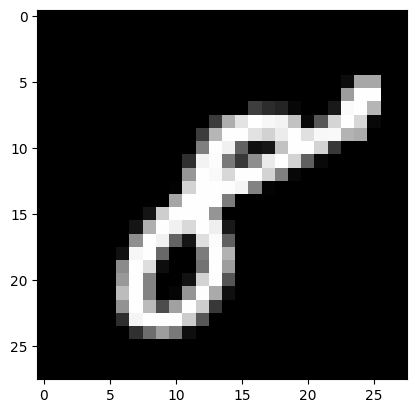

Label: 8


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=2)

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Dimensiones del batch (X): {train_features.size()}")
print(f"Dimensiones del batch (y): {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

Como puedes ver en el ejemplo anterior, estamos cargando 64 imágenes al mismo tiempo y el DataLoader nos devuelve dos tensores. El primero tiene un tamaño de **64x1x28x28**, que corresponde a 64 imagenes con un solo canal y unas dimensiones de 28x28 pixeles. Las etiquetas vendrán en un tensor unidimensional con un tamaño de 64. 

### Orden de carga de los ejemplos

Como puedes ver en el ejemplo anterior, los ejemplos se cargan secuencialmente. Con el atributo **shuffle** controlamos si queremos que los ejemplos se desordenen antes de ser devueltos. Pero, gracias al DataLoader, podemos controlar de manera más fina el orden de los ejemplos. Para ello necesitamos usar el parámetro **sampler** y **batch_sampler** del DataLoader.

### Ejercicios propuestos
1. Modifica la clase CustomImageDataset para que no haga falta pasarle las etiquetas de los ejemplos y las coja del subdirectorio en el que se encuentre la imagen.
2. Crea un batch sampler personalizado para que en cada batch los números vayan ordenados de menor a mayor.